# Lab: Frequent Itemset Mining - Data Mining CSC14004
**Họ tên:** Lê Hoàng Vũ  
**MSSV:** 22120461


📌 Ghi chú: 

Trong quá trình thực hiện bài lab này, em ban đầu có ý định sử dụng các thư viện như `fim`, `spmf`, hoặc `pami` để triển khai các thuật toán khai phá tập phổ biến như Apriori, Eclat, Charm và GenMax. Tuy nhiên, do gặp một số khó khăn trong quá trình cài đặt và tích hợp các thư viện này (đặc biệt liên quan đến nền tảng `Java` của `spmf` hay sự tương thích của hệ thống với `fim`), em đã quyết định **triển khai các thuật toán một cách thủ công bằng Python**. Dù gặp một số hạn chế nhưng em nghĩ đây cũng là một phương án tốt, với những lý do sau:

- Cài đặt thủ công giúp em dễ theo dõi và kiểm soát các thuật toán hơn: Khi tự cài đặt các thuật toán, em có thể quan sát rõ từng bước như sinh ứng viên, tính toán `support`, loại bỏ tập con,... Qua đó cũng hiểu rõ hơn bản chất từng thuật toán thay vì chỉ sử dụng thư viện.

- Dễ điều chỉnh logic, các tham số & debug: Cài đặt thủ công cho phép em dễ dàng điều chỉnh thuật toán, ghi log từng bước trung gian mỗi khi cần kiểm tra, debug và xác định các ngưỡng `minsup` phù hợp để đảm bảo hiệu suất vẫn trong tầm kiểm soát. Với dữ liệu khoảng 38,000 dòng như ở Lab này, em cũng có lựa chọn các mức `minsup` vừa phải như ở phần dưới để đảm bảo:
   - Tập phổ biến không quá nhiều, thuật toán không chạy quá lâu, và có thể tự điều chỉnh cho phù hợp.
   - Vẫn quan sát được sự khác biệt về hiệu suất giữa các thuật toán: với những ngưỡng minsup từ 0.01 trở lên, các thư viện như fim, pami, ... thường chạy rất nhanh, gần như sẽ khó quan sát sự khác biệt về thời gian thực thi, nên cũng khó nhận xét, so sánh hiệu suất. Với cách code thủ công thì những ngưỡng tương tự đã cho ra sự khác biệt rõ rệt về hiệu suất rồi. 

- Đảm bảo tính công bằng khi so sánh: Vì tất cả các thuật toán được triển khai theo cùng một phong cách Python, và tuân theo các thuật toán từ [slide bài giảng Khai thác tập phổ biến](https://courses.fit.hcmus.edu.vn/pluginfile.php/220057/mod_resource/content/1/FrequentItemsetMining.pdf) được học trên lớp, em có thể đo thời gian và so sánh hiệu quả một cách công bằng – không bị ảnh hưởng bởi tối ưu hóa ngầm của các thư viện ngoài.


Nói tóm lại, em cũng nghĩ việc không sử dụng thư viện ngoài là một hạn chế về hiệu suất, nhưng trong hoàn cảnh cụ thể của bài lab này, việc cài đặt thủ công các thuật toán vẫn là một lựa chọn phù hợp và hợp lý. Nó không chỉ giúp em kiểm soát được quá trình debug, mà còn mang lại cơ hội hiểu sâu hơn về bản chất và đặc điểm của từng thuật toán trong khai phá tập phổ biến. 

Song, vấn đề gặp khó trong việc cài đặt các thư viện này vẫn là lỗi ở em và em cũng xin được xin lỗi thầy nếu thầy có gặp cản trở gì với việc em không sử dụng thư viện ạ. Em xin cảm ơn thầy ạ.


## I. Tiền xử lý dữ liệu
Đầu tiên ta sẽ tải tập dữ liệu [Groceries](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset) và tạo danh sách các giao dịch. Mỗi giao dịch được xác định bởi một cặp *Member_number* và *Date* duy nhất. Ta nhóm dữ liệu theo các trường này và tổng hợp các mặt hàng được mua thành một danh sách chuỗi. Danh sách các giao dịch này sẽ được sử dụng cho việc khai thác tập phổ biến.

In [33]:
import pandas as pd
# Tải dữ liệu
df = pd.read_csv('data/Groceries_dataset.csv')
print("Tổng số bản ghi:", df.shape[0])

# Hiển thị vài dòng đầu để kiểm tra
print(df.head().to_string(index=False))

# Nhóm theo Member_number và Date để tạo các giao dịch
transactions = df.groupby(['Member_number','Date'])['itemDescription'] \
                 .apply(lambda x: list(set(x))) \
                 .tolist()
print("\nSố lượng giao dịch:", len(transactions))
print("Ví dụ một vài giao dịch đầu:")
for t in transactions[:3]:
    print(t)


Tổng số bản ghi: 38765
 Member_number       Date  itemDescription
          1808 21-07-2015   tropical fruit
          2552 05-01-2015       whole milk
          2300 19-09-2015        pip fruit
          1187 12-12-2015 other vegetables
          3037 01-02-2015       whole milk

Số lượng giao dịch: 14963
Ví dụ một vài giao dịch đầu:
['semi-finished bread', 'whole milk', 'yogurt', 'sausage']
['whole milk', 'pastry', 'salty snack']
['misc. beverages', 'canned beer']


Để dễ quan sát hơn thì có thể chuẩn hóa theo về bảng với Transaction ID và danh sách các mặt hàng (về giống kiểu TID - Items)

Để làm điều này, ta sẽ gộp các mặt hàng (items) lại theo từng giao dịch duy nhất được xác định bởi cặp `(Member_number, Date)`. Mỗi dòng trong bảng kết quả sẽ gồm:

- `TID`: số thứ tự giao dịch (đánh số từ 1)
- `Transaction_ID`: chuỗi mã định danh gồm `Member_number` và `Date`
- `Items`: danh sách các sản phẩm được sắp xếp theo thứ tự chữ cái

Việc chuẩn hóa này giúp hiểu rõ hơn về `transactions` trước khi cài đặt các thuật toán khai phá luật kết hợp như Apriori, Eclat, CHARM, GenMax.

In [34]:
# Lấy lại danh sách Transaction ID gốc (Member_number + Date)
transaction_ids = df.groupby(['Member_number', 'Date'])['itemDescription'] \
    .apply(lambda x: list(set(x))).reset_index()

# Gán TID tự tăng và giữ nguyên Transaction ID gốc
tid_items = pd.DataFrame({
    "TID": range(1, len(transactions) + 1),
    "Transaction_ID": transaction_ids['Member_number'].astype(str) + "_" + transaction_ids['Date'].astype(str),
    "Items": [", ".join(sorted(t)) for t in transactions]
})

# Hiển thị vài dòng đầu
print("Ví dụ bảng TID – Transaction ID – Items:")
display(tid_items.head(10))


Ví dụ bảng TID – Transaction ID – Items:


,TID,Transaction_ID,Items
0,1,1000_15-03-2015,"sausage, semi-finished bread, whole milk, yogurt"
1,2,1000_24-06-2014,"pastry, salty snack, whole milk"
2,3,1000_24-07-2015,"canned beer, misc. beverages"
3,4,1000_25-11-2015,"hygiene articles, sausage"
4,5,1000_27-05-2015,"pickled vegetables, soda"
5,6,1001_02-05-2015,"curd, frankfurter"
6,7,1001_07-02-2014,"rolls/buns, sausage, whole milk"
7,8,1001_12-12-2014,"soda, whole milk"
8,9,1001_14-04-2015,"beef, white bread"
9,10,1001_20-01-2015,"frankfurter, soda, whipped/sour cream"


## II. Khai thác tập phổ biến (Apriori và Eclat)
Ta triển khai hai thuật toán khai thác tập phổ biến: Apriori (chiều rộng, sinh ứng viên) và Eclat (chiều sâu, giao TID). Cả hai thuật toán nhận đầu vào là danh sách giao dịch đã tiền xử lý và tạo ra tất cả các tập phổ biến thoả ngưỡng hỗ trợ tối thiểu. Trong đó:
- **Apriori:** Sinh dần các tập ứng viên và lọc theo support.
- **Eclat:** Duyệt đệ quy và giao các tập TID để sinh tập lớn hơn.


Ở đây em chọn ba ngưỡng **minsup** `0.05%`, `0.5%` và `5%` nhằm thể hiện sự khác biệt giữa các chiến lược khai thác và kiểm tra khả năng hoạt động của thuật toán trong cả ba tình huống: dữ liệu thưa, trung bình và dày đặc. Cụ thể là:
- `5%`: đại diện cho mức ngưỡng cao, chỉ khai thác các tập phổ biến rất mạnh, phù hợp với dữ liệu có tần suất lặp lại cao.
- `0.5%`: là ngưỡng trung bình, giúp phát hiện được nhiều tập hơn mà vẫn giữ được tính thực tiễn.
- `0.05%`: là ngưỡng thấp, cho phép phát hiện cả những tập phổ biến hiếm gặp. Tuy nhiên, số lượng tập sinh ra sẽ rất lớn, phù hợp để đánh giá hiệu suất và khả năng mở rộng của từng thuật toán, thông qua việc so sánh thời gian thực thi của các thuật toán.



In [35]:
import time
from itertools import combinations
from collections import Counter, defaultdict

def run_algorithm(name, func, transactions, min_sup_counts):
    for sup_pct, sup_count in min_sup_counts.items():
        print("=" * 80)
        print(f"{name.upper()} - minsup = {sup_pct} ({sup_count} giao dịch tối thiểu)")
        print("-" * 80)

        start = time.time()
        freq_sets, support_data = func(transactions, sup_count)
        duration = time.time() - start

        print(f"Tổng số tập phổ biến tìm được: {len(freq_sets)}")
        print(f"Thời gian thực thi: {duration:.3f} giây")

        # Chuyển hết về frozenset để đồng bộ
        freq_sets = [frozenset(s) for s in freq_sets]

        # Phân loại theo độ dài
        freq_by_len = defaultdict(list)
        for itemset in freq_sets:
            freq_by_len[len(itemset)].append(itemset)

        # 1-itemsets
        if freq_by_len[1]:
            freq1 = sorted(
                [(list(s)[0], support_data[s]) for s in freq_by_len[1]],
                key=lambda x: -x[1]
            )
            print("\nVí dụ 1-itemsets (top 5):")
            for item, sup in freq1[:5]:
                print(f"  - {item:<20} support: {sup}")

        # 2-itemsets
        if freq_by_len[2]:
            print("\nVí dụ 2-itemsets (top 10):")
            for s in sorted(freq_by_len[2], key=lambda s: sorted(s))[:10]:
                items = ", ".join(sorted(s))
                print(f"  - {{{items}}} support: {support_data[s]}")

        # 3-itemsets
        if freq_by_len[3]:
            print("\nVí dụ 3-itemsets (top 10):")
            for s in sorted(freq_by_len[3], key=lambda s: sorted(s))[:10]:
                items = ", ".join(sorted(s))
                print(f"  - {{{items}}} support: {support_data[s]}")

        # Phân bố độ dài
        print("\nPhân bố số lượng tập phổ biến theo độ dài:")
        for k in sorted(freq_by_len):
            print(f"  - {k}-itemsets: {len(freq_by_len[k])}")


In [36]:
# Khai báo ngưỡng hỗ trợ tối thiểu (min_support) theo tỷ lệ phần trăm
total_trans = len(transactions)
min_sup_counts = { '0.05%': int(0.0005*total_trans), '0.5%': int(0.005*total_trans), '5%': int(0.05*total_trans) }

### Thuật toán Apriori:
Apriori khai thác tính chất: mọi tập con của một tập phổ biến đều phải phổ biến:
- Bắt đầu từ các 1-itemset, sau đó lặp lại quá trình tạo và kiểm tra tập ứng viên độ dài k từ các tập phổ biến độ dài k−1.
- Mỗi lần lặp gồm 2 bước: tạo tập ứng viên và đếm support trong toàn bộ cơ sở dữ liệu. 


⚙️ Mã giả thuật toán Apriori 

```python
def Apriori(D, minsup):
    # D: cơ sở dữ liệu các giao tác
    # minsup: ngưỡng hỗ trợ tối thiểu
    # L: tập các itemset phổ biến
    L = []
    
    # 1. Tạo tập L1 từ các 1-itemset thỏa minsup
    L1 = get_frequent_1_itemsets(D, minsup)
    L.append(L1)
    
    k = 2
    while L[k-2] is not empty:
        # 2. Sinh tập ứng viên Ck từ Lk-1
        Ck = apriori_gen(L[k-2])
        
        # 3. Đếm tần suất cho các ứng viên
        for transaction in D:
            Ct = subset(Ck, transaction)
            for c in Ct:
                c.count += 1

        # 4. Lọc ra các ứng viên đủ minsup
        Lk = {c for c in Ck if c.count >= minsup}
        L.append(Lk)
        k += 1
    
    return union_all(L)

In [37]:
# Cài đặt thuật toán Apriori
def apriori(transactions, min_support):
    """
    transactions: Danh sách các giao dịch (mỗi giao dịch là 1 danh sách item).
    min_support: ngưỡng hỗ trợ tối thiểu (tính theo số lượng).
    Trả về: (danh sách tập phổ biến, thông tin bổ sung).
    """
    N = len(transactions)
    item_counts = Counter()
    for t in transactions:
        for item in t:
            item_counts[item] += 1
    # Lọc các item đơn có support >= minsup
    L1 = [frozenset([item]) for item, cnt in item_counts.items() if cnt >= min_support]
    support_data = {frozenset([item]): cnt for item, cnt in item_counts.items() if cnt >= min_support}
    L = {1: L1}
    k = 1
    while True:
        k += 1
        Ck = []
        Lk_1 = L.get(k-1, [])
        if not Lk_1:
            break
        for i in range(len(Lk_1)):
            for j in range(i+1, len(Lk_1)):
                s1 = list(Lk_1[i])
                s2 = list(Lk_1[j])
                s1.sort(); s2.sort()
                if s1[:-1] == s2[:-1]:
                    candidate = frozenset(Lk_1[i] | Lk_1[j])
                    if candidate not in Ck:
                        Ck.append(candidate)
        # Loại bỏ các ứng viên không có đủ tập con
        Ck_pruned = []
        for candidate in Ck:
            all_subsets = True
            for subset in combinations(candidate, k-1):
                if frozenset(subset) not in Lk_1:
                    all_subsets = False
                    break
            if all_subsets:
                Ck_pruned.append(candidate)
        # Đếm support
        Ck_counts = defaultdict(int)
        for t in transactions:
            tset = set(t)
            for cand in Ck_pruned:
                if cand.issubset(tset):
                    Ck_counts[cand] += 1
        Lk = [cand for cand, cnt in Ck_counts.items() if cnt >= min_support]
        if not Lk:
            break
        L[k] = Lk
        for cand, cnt in Ck_counts.items():
            if cnt >= min_support:
                support_data[cand] = cnt
    all_freq = []
    for size in L:
        all_freq.extend(L[size])
    return all_freq, support_data

# Chạy Apriori với các ngưỡng minsup khác nhau (chỗ này dùng để chạy thử nghiệm, có thể dùng được)
# for sup_pct, sup_count in min_sup_counts.items():
#     start = time.time()
#     freq_sets, support_data = apriori(transactions, sup_count)
#     duration = time.time() - start
#     freq1 = sorted([(list(x)[0], support_data[x]) for x in freq_sets if len(x)==1], key=lambda x: -x[1])
#     print(f"Apriori minsup={sup_pct} (số lượng {sup_count}): Tổng số tập={len(freq_sets)}; thời gian={duration:.3f}s")
#     print(f"  Ví dụ (top 5 tập 1-item): {freq1[:5]}")
#     lengths = Counter(len(x) for x in freq_sets)
#     print(f"  Phân bố theo độ dài: {dict(lengths)}\n")


In [38]:
# Chạy thuật toán Apriori với các ngưỡng hỗ trợ khác nhau
run_algorithm("Apriori", apriori, transactions, min_sup_counts)

APRIORI - minsup = 0.05% (7 giao dịch tối thiểu)
--------------------------------------------------------------------------------
Tổng số tập phổ biến tìm được: 1678
Thời gian thực thi: 27.411 giây

Ví dụ 1-itemsets (top 5):
  - whole milk           support: 2363
  - other vegetables     support: 1827
  - rolls/buns           support: 1646
  - soda                 support: 1453
  - yogurt               support: 1285

Ví dụ 2-itemsets (top 10):
  - {Instant food products, whole milk} support: 8
  - {UHT-milk, beef} support: 7
  - {UHT-milk, bottled beer} support: 14
  - {UHT-milk, bottled water} support: 16
  - {UHT-milk, brown bread} support: 8
  - {UHT-milk, butter} support: 7
  - {UHT-milk, butter milk} support: 9
  - {UHT-milk, canned beer} support: 9
  - {UHT-milk, chicken} support: 9
  - {UHT-milk, citrus fruit} support: 12

Ví dụ 3-itemsets (top 10):
  - {beef, other vegetables, whole milk} support: 8
  - {beef, whipped/sour cream, whole milk} support: 7
  - {bottled beer, rolls/

### Thuật toán Eclat (Depth-first với giao TID)

Thay vì duyệt qua từng giao dịch, Eclat xây dựng danh sách các giao dịch chứa từng item (tidset) 
và thực hiện giao nhau các tidset để xây dựng tập lớn hơn.

⚙️ Mã giả thuật toán Eclat:
```python
def Eclat(P):
    for mỗi Xi in P:
        Ti = ∅
        for mỗi Xj in P, với j > i:
            R = Xi ∪ Xj
            t(R) = t(Xi) ∩ t(Xj)
            if support(R) ≥ minsup:
                Ti = Ti ∪ {R}
                F = F ∪ {R}
        if Ti ≠ ∅:
            Eclat(Ti)
```


In [39]:
# Cài đặt thuật toán Eclat
def eclat(transactions, min_support):
    """
    transactions: Danh sách các giao dịch.
    min_support: ngưỡng hỗ trợ tối thiểu.
    Trả về: (danh sách tập phổ biến, từ điển hỗ trợ).
    """
    # Tạo TID set cho từng item
    item_tid = {}
    for tid, trans in enumerate(transactions):
        for item in trans:
            item_tid.setdefault(item, set()).add(tid)
    # Lọc các item có support >= minsup
    items = sorted([item for item, tids in item_tid.items() if len(tids) >= min_support])
    items_tid = [(item, item_tid[item]) for item in items]
    results = []
    support_data = {}

    # Hàm đệ quy Eclat
    def recurse(prefix, items_list):
        for i in range(len(items_list)):
            item, tids = items_list[i]
            if len(tids) >= min_support:
                new_itemset = prefix + [item]
                results.append(new_itemset)
                support_data[frozenset(new_itemset)] = len(tids)
                suffix = []
                for j in range(i+1, len(items_list)):
                    item2, tids2 = items_list[j]
                    inter = tids.intersection(tids2)
                    if len(inter) >= min_support:
                        suffix.append((item2, inter))
                recurse(new_itemset, suffix)

    recurse([], items_tid)
    all_freq = [set(x) for x in results]
    return all_freq, support_data

# Chạy Eclat với các ngưỡng support (chỗ này dùng để chạy thử nghiệm, có thể dùng được)

# for sup_pct, sup_count in min_sup_counts.items():
#     start = time.time()
#     freq_sets, support_data = eclat(transactions, sup_count)
#     duration = time.time() - start
#     freq1 = sorted(
#         [(list(itemset)[0], support) for itemset, support in support_data.items() if len(itemset) == 1],
#         key=lambda x: -x[1]
#     )
#     print(f"Eclat minsup={sup_pct} (số lượng {sup_count}): Tổng số tập={len(freq_sets)}; thời gian={duration:.3f}s")
#     print(f"  Ví dụ (top 5 tập 1-item): {freq1[:5]}")
#     lengths = Counter(len(x) for x in freq_sets)
#     print(f"  Phân bố theo độ dài: {dict(lengths)}\n")


In [40]:
# Chạy thuật toán Eclat với các ngưỡng hỗ trợ khác nhau
run_algorithm("Eclat", eclat, transactions, min_sup_counts)

ECLAT - minsup = 0.05% (7 giao dịch tối thiểu)
--------------------------------------------------------------------------------
Tổng số tập phổ biến tìm được: 1678
Thời gian thực thi: 0.040 giây

Ví dụ 1-itemsets (top 5):
  - whole milk           support: 2363
  - other vegetables     support: 1827
  - rolls/buns           support: 1646
  - soda                 support: 1453
  - yogurt               support: 1285

Ví dụ 2-itemsets (top 10):
  - {Instant food products, whole milk} support: 8
  - {UHT-milk, beef} support: 7
  - {UHT-milk, bottled beer} support: 14
  - {UHT-milk, bottled water} support: 16
  - {UHT-milk, brown bread} support: 8
  - {UHT-milk, butter} support: 7
  - {UHT-milk, butter milk} support: 9
  - {UHT-milk, canned beer} support: 9
  - {UHT-milk, chicken} support: 9
  - {UHT-milk, citrus fruit} support: 12

Ví dụ 3-itemsets (top 10):
  - {beef, other vegetables, whole milk} support: 8
  - {beef, whipped/sour cream, whole milk} support: 7
  - {bottled beer, rolls/bun

## III. Khai thác tập phổ biến đóng và tối đại (Charm và GenMax)

- **Tập phổ biến đóng:** không có tập phổ biến lớn hơn nào có cùng độ hỗ trợ.
- **Tập phổ biến tối đại:** không có tập phổ biến nào là tập cha của nó.


Trong trường hợp không sử dụng thư viện có sẵn để gọi trực tiếp các thuật toán CHARM hoặc GenMax, có thể tiếp cận bài toán theo hai hướng chính như sau:

---

### Hướng 1: Dựa trên thuật toán Apriori kết hợp với bước lọc

- Thực hiện tìm tất cả các tập phổ biến (frequent itemsets) bằng thuật toán Apriori đã cài đặt.
- Sau đó thực hiện lọc lại các tập:
  - **Tập phổ biến đóng (closed itemsets)**: là các tập phổ biến mà không tồn tại tập phổ biến lớn hơn nào có cùng độ hỗ trợ.
  - **Tập phổ biến tối đại (maximal itemsets)**: là các tập phổ biến mà không tồn tại tập phổ biến nào là tập cha của nó.

**Ưu điểm**:
- Dễ cài đặt, có thể tận dụng lại kết quả từ thuật toán Apriori.
- Phù hợp để kiểm tra nhanh hoặc xử lý các tập dữ liệu nhỏ.

**Hạn chế**:
- Không phản ánh đúng bản chất thuật toán CHARM hoặc GenMax.
- Không tận dụng được các chiến lược tỉa nhánh và tối ưu hóa đặc trưng của từng thuật toán.
- Tốn thời gian và bộ nhớ nếu số lượng tập phổ biến rất lớn.


In [41]:
# Tìm tập đóng từ kết quả Apriori
def find_closed(freq_sets, support_data):
    """Trả về tập đóng (không có tập cha nào có cùng support)."""
    closed = []
    for s in freq_sets:
        is_closed = True
        for t in freq_sets:
            if s != t and s.issubset(t) and support_data.get(s, 0) == support_data.get(t, -1):
                is_closed = False
                break
        if is_closed:
            closed.append(s)
    return closed

# Tìm tập tối đại từ tập phổ biến
def find_maximal(freq_sets):
    """Trả về tập tối đại (không có tập cha nào cũng phổ biến)."""
    maximal = []
    for s in freq_sets:
        is_maximal = True
        for t in freq_sets:
            if s != t and s.issubset(t):
                is_maximal = False
                break
        if is_maximal:
            maximal.append(s)
    return maximal

for sup_pct, sup_count in min_sup_counts.items():
    freq_sets, support_data = apriori(transactions, sup_count)
    closed_sets = find_closed(freq_sets, support_data)
    maximal_sets = find_maximal(freq_sets)
    # Chạy tìm closed và maximal từ kết quả Apriori (chỗ này dùng để chạy thử nghiệm, có thể dùng được)
    print(f"Charm (tập đóng) minsup={sup_pct}: Số lượng={len(closed_sets)}; phân bố độ dài: {Counter(len(s) for s in closed_sets)}")
    print(f"GenMax (tối đại) minsup={sup_pct}: Số lượng={len(maximal_sets)}; phân bố độ dài: {Counter(len(s) for s in maximal_sets)}\n")

Charm (tập đóng) minsup=0.05%: Số lượng=1678; phân bố độ dài: Counter({2: 1403, 1: 158, 3: 117})
GenMax (tối đại) minsup=0.05%: Số lượng=1442; phân bố độ dài: Counter({2: 1280, 3: 117, 1: 45})

Charm (tập đóng) minsup=0.5%: Số lượng=130; phân bố độ dài: Counter({1: 90, 2: 40})
GenMax (tối đại) minsup=0.5%: Số lượng=111; phân bố độ dài: Counter({1: 71, 2: 40})

Charm (tập đóng) minsup=5%: Số lượng=11; phân bố độ dài: Counter({1: 11})
GenMax (tối đại) minsup=5%: Số lượng=11; phân bố độ dài: Counter({1: 11})



### Hướng 2: Cài đặt thuật toán CHARM và GenMax từ đầu

- Thực hiện cài đặt độc lập đúng theo các bước của từng thuật toán:
  - **CHARM**: sử dụng biểu diễn dữ liệu theo dạng dọc (vertical data format với tidset), mở rộng tập theo từng bước và áp dụng các thuộc tính CHARM để tỉa bớt nhánh không cần thiết. Kết quả thu được là các tập phổ biến đóng.
  - **GenMax**: xây dựng cây ứng viên và thực hiện duyệt kết hợp cùng các phép kiểm tra bao phủ (subset-checking) với danh sách tập tối đại đã sinh trước đó. Kết quả thu được là các tập phổ biến tối đại.

**Ưu điểm**:
- Phản ánh chính xác logic và tối ưu của từng thuật toán.
- Có thể đánh giá, so sánh hiệu năng thực sự của từng phương pháp.

**Hạn chế**:
- Cài đặt phức tạp hơn, dễ bị nhầm lẫn khi cài đặt các trường hợp tỉa nhánh. 
- Cần xử lý tốt các thao tác CHARM trên tập hợp để đảm bảo hiệu quả.

---

#### ⚙️ Mã giả thuật toán Charm 
```python
def CHARM(D, minsup):
    # Tạo danh sách các 1-itemset với tidset
    for mỗi lớp [P]:
        CHARM_EXTEND([P])
    # Trả về tất cả tập phổ biến đóng

def CHARM_EXTEND(P):
    for li × t(li) in P:
        for lj × t(lj), j > i:
            R = li ∪ lj
            t(R) = t(li) ∩ t(lj)
            if support(R) ≥ minsup:
                áp dụng CHARM-PROPERTY để xử lý và tỉa
            CHARM_EXTEND([R])  # Đệ quy

```

#### ⚙️ Mã giả thuật toán GenMax 

```python
def MFI_backtrack(I, C, l):
    for x in C:
        I_prime = I ∪ {x}
        P_prime = {y in C | y > x}
        if I_prime ∪ P_prime bị bao bởi tập tối đại:
            continue  # bỏ qua nhánh này
        C_prime = FI_combine(I_prime, P_prime)
        if C_prime is empty:
            if I_prime không bị bao bởi tập nào trong MFI:
                thêm I_prime vào MFI
        else:
            MFI_backtrack(I_prime, C_prime, l+1)
```

In [42]:
# Chuyển đổi danh sách giao dịch thành TID-set cho từng item đơn
def get_tidsets(transactions):
    item_tidsets = defaultdict(set)
    for tid, trans in enumerate(transactions):
        for item in trans:
            item_tidsets[frozenset([item])].add(tid)
    return item_tidsets

# Cài đặt thuật toán Charm
def charm(transactions, minsup):
    item_tidsets = get_tidsets(transactions)
    support_data = {}
    closed_sets = []

    # Hàm đệ quy mở rộng tập với các item tiếp theo để sinh tập lớn hơn.
    def charm_extend(prefix, prefix_tidset, items):
        for i, (item, tidset) in enumerate(items):
            new_set = prefix | item
            new_tidset = prefix_tidset & tidset
            if len(new_tidset) >= minsup:
                # Kiểm tra có bị bao bởi tập cha nào không (có cùng support)
                is_closed = True
                for other in closed_sets:
                    if new_set < other and support_data[other] == len(new_tidset):
                        is_closed = False
                        break
                if is_closed:
                    # Loại bỏ các tập con đã tồn tại nếu bị new_set bao với cùng support
                    closed_sets[:] = [s for s in closed_sets if not (s < new_set and support_data[s] == len(new_tidset))]
                    closed_sets.append(new_set)
                    support_data[new_set] = len(new_tidset)
                    charm_extend(new_set, new_tidset, items[i+1:])

    # Khởi tạo và bắt đầu đệ quy
    items = sorted(item_tidsets.items(), key=lambda x: sorted(x[0]))
    charm_extend(frozenset(), set(range(len(transactions))), items)
    return closed_sets, support_data

In [43]:
# Charm với các ngưỡng hỗ trợ khác nhau
run_algorithm("Charm", charm, transactions, min_sup_counts)


CHARM - minsup = 0.05% (7 giao dịch tối thiểu)
--------------------------------------------------------------------------------
Tổng số tập phổ biến tìm được: 1678
Thời gian thực thi: 0.145 giây

Ví dụ 1-itemsets (top 5):
  - whole milk           support: 2363
  - other vegetables     support: 1827
  - rolls/buns           support: 1646
  - soda                 support: 1453
  - yogurt               support: 1285

Ví dụ 2-itemsets (top 10):
  - {Instant food products, whole milk} support: 8
  - {UHT-milk, beef} support: 7
  - {UHT-milk, bottled beer} support: 14
  - {UHT-milk, bottled water} support: 16
  - {UHT-milk, brown bread} support: 8
  - {UHT-milk, butter} support: 7
  - {UHT-milk, butter milk} support: 9
  - {UHT-milk, canned beer} support: 9
  - {UHT-milk, chicken} support: 9
  - {UHT-milk, citrus fruit} support: 12

Ví dụ 3-itemsets (top 10):
  - {beef, other vegetables, whole milk} support: 8
  - {beef, whipped/sour cream, whole milk} support: 7
  - {bottled beer, rolls/bun

In [44]:
def genmax(transactions, minsup):
    item_tidsets = get_tidsets(transactions)
    maximal_sets = []
    support_data = {}

    # Hàm kiểm tra xem tập con có bị bao bởi tập tối đại nào không
    def is_subsumed(candidate):
        for s in maximal_sets:
            if candidate < s:
                return True
        return False

    # Hàm đệ quy để tìm tập tối đại
    def backtrack(prefix, prefix_tidset, items):
        for i, (item, tidset) in enumerate(items):
            new_set = prefix | item # Hợp item vào tập prefix hiện tại
            new_tidset = prefix_tidset & tidset # Giao TID để lấy support của tập mới
            if len(new_tidset) >= minsup: # Chỉ mở rộng nếu đủ support
                new_items = []
                for j in range(i + 1, len(items)):
                    item_j, tidset_j = items[j]
                    intersect_tidset = new_tidset & tidset_j
                    if len(intersect_tidset) >= minsup:
                        new_items.append((item_j, tidset_j))

                if not new_items:
                    # Nếu không thể mở rộng nữa và không bị bao bởi tập tối đại nào
                    if not is_subsumed(new_set):
                        maximal_sets.append(new_set)
                        support_data[new_set] = len(new_tidset)
                else:
                    # Nếu còn item có thể mở rộng, tiếp tục đệ quy
                    backtrack(new_set, new_tidset, new_items)

    # Bắt đầu đệ quy từ tập rỗng
    items = sorted(item_tidsets.items(), key=lambda x: sorted(x[0]))
    backtrack(frozenset(), set(range(len(transactions))), items)
    return maximal_sets, support_data


In [45]:
# Chạy thuật toán GenMax với các ngưỡng hỗ trợ khác nhau
run_algorithm("GenMax", genmax, transactions, min_sup_counts)

GENMAX - minsup = 0.05% (7 giao dịch tối thiểu)
--------------------------------------------------------------------------------
Tổng số tập phổ biến tìm được: 1442
Thời gian thực thi: 0.072 giây

Ví dụ 1-itemsets (top 5):
  - rice                 support: 49
  - curd cheese          support: 46
  - sparkling wine       support: 46
  - sauces               support: 44
  - cereals              support: 42

Ví dụ 2-itemsets (top 10):
  - {Instant food products, whole milk} support: 8
  - {UHT-milk, beef} support: 7
  - {UHT-milk, bottled beer} support: 14
  - {UHT-milk, bottled water} support: 16
  - {UHT-milk, brown bread} support: 8
  - {UHT-milk, butter} support: 7
  - {UHT-milk, butter milk} support: 9
  - {UHT-milk, canned beer} support: 9
  - {UHT-milk, chicken} support: 9
  - {UHT-milk, citrus fruit} support: 12

Ví dụ 3-itemsets (top 10):
  - {beef, other vegetables, whole milk} support: 8
  - {beef, whipped/sour cream, whole milk} support: 7
  - {bottled beer, rolls/buns, whole 

## IV. Trực quan hóa kết quả & Phân tích

Dưới đây là các biểu đồ so sánh:

- Số lượng tập phổ biến được phát hiện bởi mỗi thuật toán tại các ngưỡng `minsup` khác nhau.
- Tỷ lệ phân bố của các tập phổ biến dựa trên độ dài.
- So sánh thời gian thực thi của các thuật toán.


### Về số lượng tập phổ biến, tập đóng và tập tối đại:

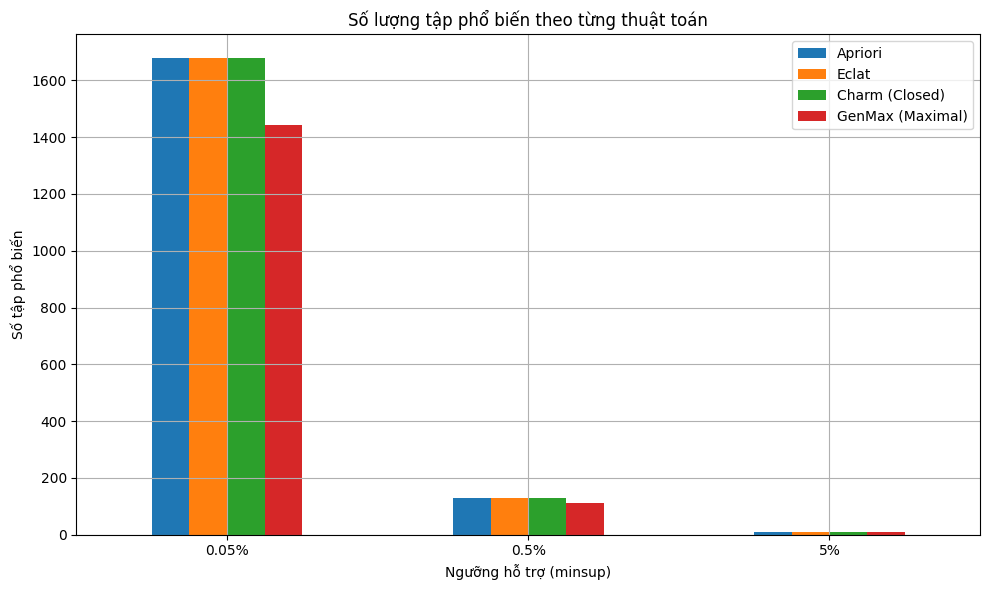

In [46]:
import matplotlib.pyplot as plt
import time
import pandas as pd

# Lưu kết quả để vẽ biểu đồ
result_summary = []

# Tính toán cho từng mức minsup với thuật toán mới (Charm và GenMax dùng thuật toán theo hướng 2)
for sup_pct, sup_count in min_sup_counts.items():
    # Apriori
    start = time.time()
    freq_sets, support_data = apriori(transactions, sup_count)
    apriori_time = time.time() - start

    # Eclat
    start = time.time()
    freq_eclat, _ = eclat(transactions, sup_count)
    eclat_time = time.time() - start

    # Charm
    start = time.time()
    closed_sets, _ = charm(transactions, sup_count)
    charm_time = time.time() - start

    # GenMax
    start = time.time()
    maximal_sets, _ = genmax(transactions, sup_count)
    genmax_time = time.time() - start

    result_summary.append({
        "minsup": sup_pct,
        "Apriori": len(freq_sets),
        "Eclat": len(freq_eclat),
        "Charm (Closed)": len(closed_sets),
        "GenMax (Maximal)": len(maximal_sets),
        "Time_Apriori": apriori_time,
        "Time_Eclat": eclat_time,
        "Time_Charm": charm_time,
        "Time_GenMax": genmax_time
    })

# Trực quan hóa
df_result = pd.DataFrame(result_summary)

# Biểu đồ số lượng tập phổ biến
df_result_plot = df_result.set_index("minsup")[["Apriori", "Eclat", "Charm (Closed)", "GenMax (Maximal)"]]
df_result_plot.plot(kind='bar', figsize=(10, 6))
plt.title("Số lượng tập phổ biến theo từng thuật toán")
plt.ylabel("Số tập phổ biến")
plt.xlabel("Ngưỡng hỗ trợ (minsup)")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


>**Nhận xét**:
>- Khi `minsup` càng cao, số lượng tập phổ biến giảm nhanh chóng.
>- Apriori và Eclat cho kết quả giống nhau về số lượng tập phổ biến. Điều này luôn xảy ra khi thuật toán hoạt động đúng. 
>- Trong khi đó, thuật toán Charm và GenMax lần lượt cho ra kết quả là số tập **đóng (closed)** và **tối đại (maximal)**. Đây là các tập con của tập phổ biến, giúp rút gọn số lượng mà vẫn giữ thông tin quan trọng. Mối quan hệ như sau:
>$$
>\text{Tập phổ biến tối đại} \subseteq \text{Tập phổ biến đóng} \subseteq \text{Tập phổ biến}
>$$
>
>Nhìn vào mối quan hệ của các tập trên, có thể dễ nhận ra:
>
>$$
>\text{|tập phổ biến tối đại|} \leq \text{|tập phổ biến đóng|} \leq \text{|tập phổ biến|}
>$$
>
>Do đó như kết quả trực quan hóa ở trên, ta nhận thấy:
>
>(i) Số tập đóng tìm được từ thuật toán Charm bằng đúng số tập phổ biến từ thuật toán Apriori và Eclat. Điều này nghĩa là với mỗi tập phổ biến X tìm được, không tồn tại tập Y nào bao tập X mà sup(X) = sup(Y). 
>
>(ii) Số tập tối đại tìm được từ thuật toán GenMax thấp hơn số tập đóng từ thuật toán Charm và số tập phổ biến từ Apriori, Eclat ở ngưỡng `minsup = 0.05 và 0.5%`, và bằng số tập đó ở ngưỡng `minsup = 5%`. Điều này nghĩa là:
>- Với ngưỡng `minsup` nhỏ, có nhiều tập phổ biến con nằm trong các tập lớn hơn, nên số tập đóng và tập phổ biến nhiều hơn so với tập tối đại.
>- Khi `minsup` tăng lên, các tập lớn bị loại bỏ dần, dẫn đến phần lớn các tập phổ biến còn lại là chính các tập tối đại, làm cho 3 tập hợp gần như trùng nhau. Và với dataset này, cùng với ngưỡng `minsup` em đã chọn ở Lab này thì số lượng phần tử 3 tập này trở nên bằng nhau.


### Về hiệu suất và thời gian thực thi:

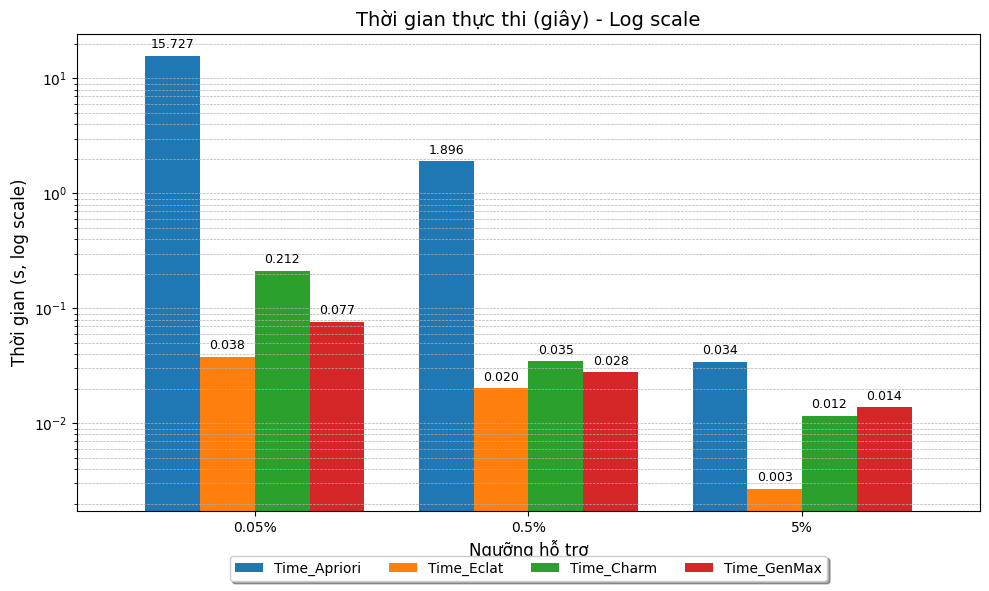

In [47]:
import numpy as np

# Biểu đồ thời gian chạy
df_time = df_result.set_index("minsup")[["Time_Apriori", "Time_Eclat", "Time_Charm", "Time_GenMax"]]
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ biểu đồ log scale
df_time.plot(kind='bar', logy=True, ax=ax, width=0.8)

plt.title("Thời gian thực thi (giây) - Log scale", fontsize=14)
plt.ylabel("Thời gian (s, log scale)", fontsize=12)
plt.xlabel("Ngưỡng hỗ trợ", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Gắn nhãn trên mỗi cột
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.3f}',
                    (p.get_x() + p.get_width() / 2, height * 1.1),
                    ha='center', va='bottom', fontsize=9, rotation=0)

# Đặt legend phía trên
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=4)

plt.tight_layout()
plt.show()



>**Nhận xét**:
>
>Biểu đồ thể hiện thời gian thực thi (log scale) của bốn thuật toán: Apriori, Eclat, Charm và GenMax, với ba ngưỡng minsup: 0.05%, 0.5%, và 5%.
>
>- Thuật toán **Eclat** cho thấy thời gian thực thi nhanh vượt trội so với Apriori, đặc biệt ở mức ngưỡng thấp. Điều này là do Eclat khai thác cấu trúc `tidset` và tránh được việc sinh ứng viên lặp lại nhiều lần như Apriori.
>
>- Quá trình trích xuất **tập phổ biến đóng** (từ Apriori sang Charm) và **tập phổ biến tối đại** (từ Apriori sang GenMax) diễn ra rất nhanh. Nguyên nhân là vì các bước này chủ yếu dựa vào việc **so sánh tập con và đối chiếu support**, không cần truy xuất lại dữ liệu ban đầu.
>
>- Apriori thể hiện thời gian thực thi kém hơn hẳn, đặc biệt tại ngưỡng 0.05%, dao động từ 15-30 giây (tùy vào trạng thái kernel hay của máy, chẳng hạn lúc em thử khi mới restart kernel thường chạy lâu hơn). Điều này cho thấy Apriori không phù hợp với ngưỡng hỗ trợ thấp hoặc tập dữ liệu lớn.
>
>- Charm và GenMax có thời gian thực thi tương đương, đều ổn định và nhanh hơn nhiều so với Apriori, đặc biệt phù hợp cho việc khai thác tập phổ biến đóng và tối đại trực tiếp.
>
>Tóm lại, để tối ưu hiệu suất:
>- Nên **tránh dùng Apriori** cho ngưỡng thấp.
>- Sử dụng **Eclat** nếu chỉ cần tìm tập phổ biến.
>- Dùng **Charm** hoặc **GenMax** khi cần tập đóng hoặc tối đại mà vẫn đảm bảo thời gian xử lý nhanh.



### Về tỷ lệ tập phổ biến theo độ dài (số phần tử)

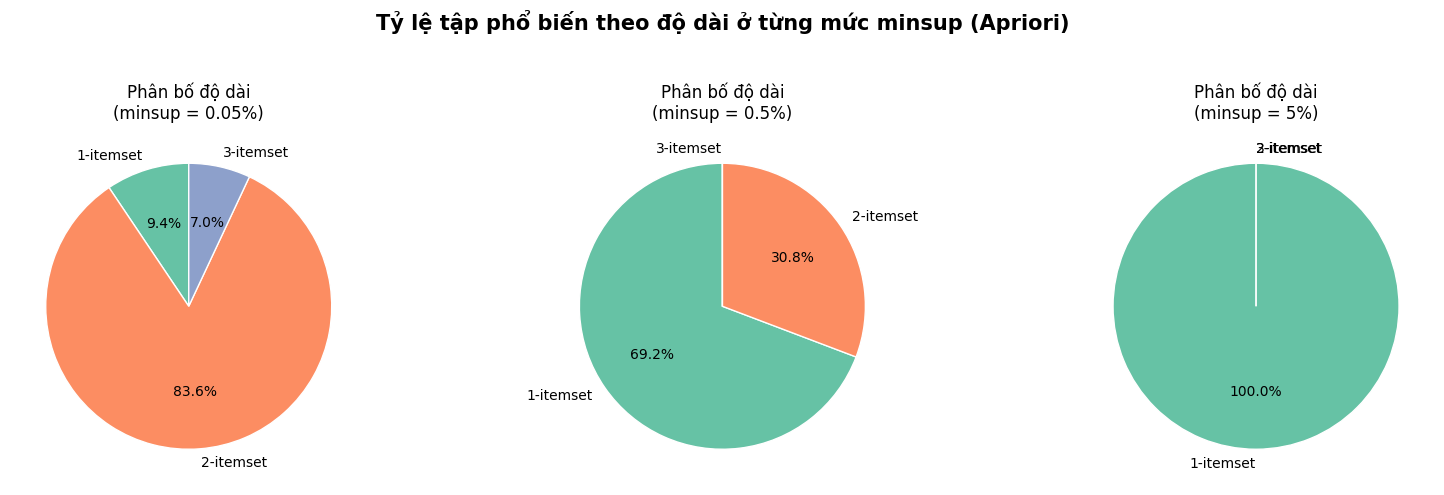

In [48]:
import matplotlib.pyplot as plt

# Dữ liệu theo độ dài tập phổ biến cho từng minsup
length_pie_data = {
    "0.05%": [158, 1403, 117],
    "0.5%": [90, 40, 0],
    "5%": [11, 0, 0]
}

labels = ["1-itemset", "2-itemset", "3-itemset"]
colors = ["#66c2a5", "#fc8d62", "#8da0cb"]

def autopct_format(pct):
    return f"{pct:.1f}%" if pct > 0 else ""

# Vẽ 3 biểu đồ tròn
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=100)

for ax, (minsup, values) in zip(axes, length_pie_data.items()):
    wedges, texts, autotexts = ax.pie(
        values,
        labels=labels,
        autopct=autopct_format,
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
        textprops={'fontsize': 10}
    )
    ax.set_title(f"Phân bố độ dài\n(minsup = {minsup})", fontsize=12)

# Tiêu đề tổng
plt.suptitle("Tỷ lệ tập phổ biến theo độ dài ở từng mức minsup (Apriori)", fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


> **Nhận xét**: Ở phần này em lựa chọn biểu đồ quạt để trực quan hóa **tỷ lệ mỗi thành phần** trong từng mức minsup tốt nhất có thể. Cụ thể ở đây là tỷ lệ phần trăm các độ dài tập phổ biến (1-itemset, 2-itemset, 3-itemset) theo từng mức `minsup`. Ở phần trực quan trên ta có thể thấy:
>
>- Khi `minsup = 0.05%`, phần lớn các tập phổ biến là **2-itemset** (chiếm hơn 80%), cho thấy thuật toán có thể khai thác sâu các kết hợp mặt hàng khi ngưỡng hỗ trợ thấp.
>
>- Ở `minsup = 0.5%`, các **1-itemset** bắt đầu chiếm ưu thế (~70%) và không còn xuất hiện **3-itemset**, chứng tỏ rằng mức hỗ trợ trung bình đã loại bỏ nhiều tổ hợp có độ phổ biến thấp.
>
>- Tại ngưỡng cao nhất `minsup = 5%`, **chỉ còn 1-itemset**, cho thấy với ngưỡng cao như 5% thì các sự kết hợp từ 2 item trở lên đã trở nên không còn phổ biến.
>
>**Kết luận**:
>- Việc tăng `minsup` giúp giảm số lượng tập phổ biến nhưng đổi lại ta có thể loại bỏ các kết hợp ít xuất hiện, tập trung hơn vào những sự kết hợp/ item phổ biến hơn.
>- Qua đó cũng thấy tầm quan trọng của việc chọn `minsup` phù hợp với mục tiêu phân tích: nếu muốn khám phá sâu những sự kết hợp nhiều item, nên chọn ngưỡng thấp (dù số lượng nhiều và thực thi có thể lâu hơn).


## V. Câu hỏi lý thuyết

### 1. **Tất cả các tập đóng (Closed Itemsets) có phải là tập phổ biến (Frequent Itemsets)?**
**Trả lời:** Sai. 

Bản chất lý do câu này sai là do tập đóng (Closed Itemset) khác tập phổ biến đóng (Closed Frequent Itemset). Tập phổ biến đóng thì chắc chắn sẽ phổ biến, nhưng tập đóng thì chưa chắc. Em xin được trích dẫn một số nội dung lý thuyết từ [slide bài giảng Khai thác tập phổ biến](https://courses.fit.hcmus.edu.vn/pluginfile.php/220057/mod_resource/content/1/FrequentItemsetMining.pdf) trên lớp (cũng có trên moodle) dưới đây để làm rõ vấn đề này:


**(i) Toán tử đóng**:

- Gọi $t(X)$: tập tất cả các TID của giao tác có chứa tập hạng mục $X$.
- Gọi $i(Y)$: tập tất cả các item tồn tại trong tất cả giao tác $Y$.
- Khi đó, toán tử đóng được định nghĩa là:
  
  $
  c = i \circ t
  $

  tức là:

  $
  c(X) = i(t(X))
  $

**(ii) Tập đóng**: Một tập hạng mục $X$ là **tập đóng** nếu:

$
c(X) = X
$

**(iii) Tập phổ biến đóng**: Một tập hạng mục $X$ là **tập phổ biến đóng** nếu:
- $X$ là tập đóng, tức là $c(X) = X$
- $\text{support}(X) \geq \text{minsup}$

> Kết luận:  
> **Tập phổ biến đóng** = **Tập đóng** + **Thoả ngưỡng minsup**

---
**Ví dụ minh họa**: Giả sử ta có cơ sở dữ liệu sau:

| TID | Items     |
|-----|-----------|
| 1   | A, B, C   |
| 2   | C, D      |
| 3   | A, B, E   |
| 4   | A, B, D   |
| 5   | A, E      |

Với ngưỡng hỗ trợ tối thiểu $ \text{minsup} = 3 $


(*) Xét tập $ X = \{A, B\} $:

- $ t(\{A, B\}) = \{1, 3, 4\} $
- $ i(\{1, 3, 4\}) = \{A, B\} $
- ⇒ $ c(\{A, B\}) = \{A, B\} \Rightarrow $ tập đóng.

Mà tập $X$ này có $ \text{support} = 3 \geq \text{minsup} $. Do đó $ \{A, B\} $ là tập phổ biến đóng.

(*) Xét tập $ X = \{C\} $:

- $ t(\{C\}) = \{1, 2\} $
- $ i(\{1, 2\}) = \{C\} $
- ⇒ $ c(\{C\}) = \{C\} \Rightarrow $ tập đóng

Mà tập $X$ này có $ \text{support} = 2 < \text{minsup} $. Do đó $ \{C\} $ tuy là tập đóng nhưng không phải là tập phổ biến hay tập phổ biến đóng.


Qua ví dụ trên, có thể thấy **mọi tập phổ biến đóng đều là tập đóng, và cũng là tập phổ biến**, nhưng **không phải mọi tập đóng đều là tập phổ biến hay tập phổ biến đóng**.


### 2. **Tất cả các tập tối đại (Maximal Itemsets) có phải là tập đóng?**
**Trả lời:** Đúng.
Ta sẽ chứng minh mọi tập tối đại đều là tập đóng (dù là tập tối đại hay tập phổ biến tối đại), khi đó nhận định ở câu 2 này là đúng. Tuy nhiên, chiều ngược lại sẽ không đúng: không phải mọi tập đóng đều là tối đại.


**(i) Trường hợp 1: Với tập phổ biến tối đại**

Trường hợp này hiển nhiên đúng do mọi tập phổ biến tối đại đều là tập phổ biến đóng, nên cũng là tập đóng. Quan hệ giữa các tập có thể hiểu như sau:

```plaintext
                    ┌────────────────────────────┐
                    │        Tập phổ biến        │
                    │   ┌────────────────────┐   │
                    │   │ Tập phổ biến đóng  │   │
                    │   │  ┌──────────────┐  │   │
                    │   │  │ Tập phổ biến │  │   │
                    │   │  │   tối đại    │  │   │
                    │   │  └──────────────┘  │   │
                    │   └────────────────────┘   │
                    └────────────────────────────┘

```


**(ii) Trường hợp 2: Tập tối đại không yêu cầu phổ biến (bỏ qua minsup)**

Giả sử $X$ là một **tập tối đại** trong tập ứng viên $\mathcal{S}$, tức là: $ X \in \mathcal{S} $ và không tồn tại tập $Y \in \mathcal{S}$ sao cho $ X \subset Y $ (1)

Xét toán tử đóng:
$
c(X) = i(t(X))
$

trong đó:
- $t(X)$: tập các giao tác (tid) chứa $X$
- $i(t(X))$: tập giao tất cả các item trong các giao tác đó

Khi đó nếu tồn tại $Y \supset X$ có cùng tập giao tác thì $c(X) = Y \supset X$, mâu thuẫn với điều kiện (1)

Do đó không tồn tại tập nào bao $X$ mà có cùng tập giao tác $ \Rightarrow c(X) = X $

Vậy $X$ là tập đóng (theo điều kiện của tập đóng).


> Kết luận: 
> Nói tóm lại, trong cả hai trường hợp, **mọi tập tối đại** (có hoặc không thỏa điều kiện phổ biến) đều là **tập đóng**. 


### 3. **Vì sao tập đóng và tập tối đại thường được ưu tiên trong khai phá luật kết hợp?**
**Trả lời:**

#### 3.1. Một số lý do về mặt lý thuyết:
**Tập đóng** giữ lại đầy đủ thông tin về độ phổ biến (support) của các tập con, do không có tập phổ biến cha nào có cùng độ hỗ trợ. Nhờ đó, tập đóng cho phép sinh ra các luật kết hợp đầy đủ và chính xác như khi dùng toàn bộ tập phổ biến, nhưng với số lượng ít hơn — giúp giảm trùng lặp và tiết kiệm không gian lưu trữ. Cụ thể là khi minsup thấp hoặc dữ liệu dày đặc, số tập phổ biến có thể rất lớn. Tập đóng giúp rút gọn mà không mất thông tin.

>Ví dụ:  
>Nếu {a, b} là tập phổ biến đóng với support = 4 thì có thể suy ra {a} và {b} có support $\geq$ 4.

**Tập tối đại** chỉ lưu các tập phổ biến lớn nhất, giúp giảm tối đa số lượng tập cần xem xét. Tuy nhiên, do không giữ thông tin support của các tập con, nên không thể khai thác đầy đủ các luật kết hợp từ tập tối đại. Do đó, tập tối đại thường được dùng khi mục tiêu là phát hiện các mẫu phổ biến tổng quát, chứ không phải sinh luật chi tiết.

>Ví dụ:  
>Nếu {a, b, c} là tập phổ biến tối đại thì các tập như {a}, {a, b} là tập phổ biến nhưng không biết support của chúng.

---

#### 3.2. Một số lý do về mặt ứng dụng thực tế:

##### Closed Frequent Itemsets

| Tác vụ                                 | Ví dụ sử dụng                                                    |
|----------------------------------------|---------------------------------------------------------------------|
| Gợi ý sản phẩm                         | Sinh luật dạng `{áo sơ mi, quần tây} → cà vạt` với support chính xác|
| Phân cụm hành vi mua sắm              | Dựa trên các mẫu xuất hiện đầy đủ để nhóm khách hàng               |
| Sinh báo cáo phân tích tiêu dùng      | Lưu trữ và khai thác đầy đủ thông tin tập phổ biến                 |

##### Maximal Frequent Itemsets

| Tác vụ                                 | Ví dụ sử dụng                                                    |
|----------------------------------------|---------------------------------------------------------------------|
| Khám phá mẫu lớn tổng quát            | Có thể tìm ra những mẫu xuất hiện nhiều, chẳng hạn như `{bút, tẩy, vở}`|
| Phân tích hành vi duyệt web           | Tìm các chuỗi trang phổ biến nhất                                  |
| Tiền xử lý phân tích sơ bộ            | Khám phá nhanh các xu hướng trước khi đi vào chi tiết              |



#### 3.3. Tổng kết

- **Tập phổ biến đóng**: nên dùng khi cần đầy đủ thông tin, hay muốn sinh luật kết hợp chính xác.
- **Tập phổ biến tối đại**: nên dùng khi cần tóm tắt nhanh, giảm số lượng mẫu và tiết kiệm bộ nhớ.

$\Rightarrow$ Có thể kết hợp cả hai: khai thác tập phổ biến đóng để sinh luật, sau đó trích xuất tập phổ biến tối đại để phân tích tóm tắt.


## VI. Tự đánh giá quá trình

Trong quá trình tìm hiểu và triển khai các thuật toán khai phá tập phổ biến như **Apriori**, **Eclat**, **CHARM** và **GenMax**, em đã rút ra được một số nhận xét quan trọng:

- **Về mặt lý thuyết**:
  - Em đã phân biệt được rõ ràng giữa các khái niệm: *frequent itemset*, *closed frequent itemset*, và *maximal frequent itemset*. Phần trả lời câu hỏi giúp em hiểu sâu hơn về tính chất bao hàm, mói quan hệ giữa các tập này và vai trò của từng loại tập trong việc khai thác luật kết hợp, ứng dụng trong thực tế ...
  - Em quyết định cài đặt các thuật toán từ đầu (from scratch) để hiểu sâu hơn về bản chất của những thuật toán này. Thực tế ta có thể dùng những thư viện như *fim*, *pami*, ... để làm nhanh hơn, hay ở các thuật toán CHARM, GenMax có thể áp dụng kết quả từ Apriori để làm tiếp. 

- **Về thực nghiệm**:
  - Qua việc quan sát các thuật toán hoạt động, em đã rút ra những kết luận có giá trị ở phần Trực quan hóa kết quả và Phân tích. Ở đó em đã so sánh giữa số lượng tập phổ biến, phổ biến đóng và phổ biến tối đại sinh ra từ các thuật toán; so sánh thời gian thực thi mỗi thuật toán, cũng như so sánh tỷ lệ các loại itemset sinh ra từ Apriori. 
  - Qua đó em cũng nhìn nhận ra những vấn đề tồn đọng ở các thuật toán này, cách cải tiến, cũng như ứng dụng của những thuật toán này trong thực tế dựa trên cách cài đặt, kết quả, ... 


- **Tự đánh giá**:
  - Em đã thực hiện đầy đủ yêu cầu: cài đặt các thuật toán, trả ra output phù hợp, phân tích kết quả theo các ngưỡng hỗ trợ, trình bày biểu đồ trực quan, giải thích những kết quả quan sát được, trả lời câu hỏi lý thuyết, ... Và em đã nghiêm túc tuân theo định dạng notebook được yêu cầu, cam kết trung thực với những nội dung được soạn trong notebook này.
  - Em tự nhận notebook này còn những thiếu sót. Nếu có thêm thời gian, em sẽ so sánh thêm những thuật toán được cài đặt từ đầu này với những thuật toán từ thư viện có sẵn để có những góc nhìn mới mẻ hơn. 


## VII. Tài liệu tham khảo

- [Mohammed J. Zaki, Wagner Meira Jr. Data Mining and Machine Learning: Fundamental Concepts and Algorithms](https://www.cs.rpi.edu/~zaki/DMML/slides/pdf/ychap9.pdf)
- [The Data Blog/ What is a maximal itemset?](https://data-mining.philippe-fournier-viger.com/what-is-a-maximal-itemset/)
- [The Data Blog/ What is a Closed Itemset and Why is it Useful?](https://data-mining.philippe-fournier-viger.com/what-is-a-closed-itemset-and-why-is-it-useful/)
- [Srikant, R., & Agrawal, R. (1995). Mining Generalized Association Rules. *VLDB*.](https://www.vldb.org/conf/1995/P407.PDF)
- [Slide bài giảng môn *Data Mining*, bài KHAI THÁC TẬP PHỔ BIẾN (Frequent ItemsetMining)](https://courses.fit.hcmus.edu.vn/pluginfile.php/220057/mod_resource/content/1/FrequentItemsetMining.pdf)